# Setup and utils

In [1]:
import numpy as np
import random
import copy
import matplotlib.pyplot as plt
import json
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from types import SimpleNamespace
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go
from scipy.interpolate import griddata
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

# ------------------------------------ MODEL UTILS ----------------------------------------------
class CustomCNN(nn.Module):
    def __init__(self, input_dim, output_dim, depth, num_channels, hidden_dim_lin, activation_function, kernel_size, use_pooling=True):
        super(CustomCNN, self).__init__()

        # Initial number of input channels, assuming grayscale images
        in_channels = 1

        # Dynamically add convolutional and activation layers based on the specified depth
        for i in range(depth):
            # Create a convolutional layer and add it to the model
            setattr(self, f"conv{i}", nn.Conv2d(in_channels, num_channels, kernel_size=kernel_size, padding=math.floor(kernel_size/2)))

            # Create an activation layer (e.g., ReLU) and add it to the model
            setattr(self, f"act{i}", activation_function())

            # Update the input dimensions after convolution
            input_dim = (input_dim - kernel_size + 2 * math.floor(kernel_size/2)) + 1

            # Optionally add pooling layers to reduce spatial dimensions
            if use_pooling and (i+1) % depth == 0:
                setattr(self, f"pool{i}", nn.MaxPool2d(2))
                input_dim = input_dim // 2

            # Update the input channels for the next convolutional layer
            in_channels = num_channels

        # Compute the size of the flattened features for the fully connected layer
        flattened_size = in_channels * input_dim * input_dim
        # Add two fully connected layers for classification
        self.fc_1 = nn.Linear(flattened_size, hidden_dim_lin)
        self.relu = activation_function()
        self.fc_2 = nn.Linear(hidden_dim_lin, output_dim)

        # Add log softmax layer for multi-class classification output
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # Iterate over each module in the CustomCNN class
        for layer_name, layer in self.named_children():
            # Process the input tensor through convolutional and activation layers
            if "conv" in layer_name or "act" in layer_name:
                x = layer(x)
            # Process the input tensor through pooling layers if they exist
            elif "pool" in layer_name:
                x = layer(x)
            # If reached fully connected layers, break the loop
            elif isinstance(layer, nn.Linear):
                break

        # Flatten the tensor to fit the input shape of the fully connected layers
        x = x.view(x.size(0), -1)
        # Pass the tensor through the fully connected layers
        x = self.fc_1(x)
        x = self.relu(x)
        x = self.fc_2(x)

        # Return log softmax activated output
        return self.logsoftmax(x)

def generate_cnn(input_dim, output_dim, depth, num_channels, hidden_dim_lin, kernel_size, activation_function=nn.ReLU, use_pooling=True):
    model = CustomCNN(input_dim, output_dim, depth, num_channels, hidden_dim_lin, activation_function, kernel_size, use_pooling)
    return model

class Trainer:
    """
    A class for training and evaluating a model with early stopping and best model saving functionalities.

    Attributes:
    - model: PyTorch model to be trained and evaluated.
    - dataloader: Contains data loaders (train, validation, test) for training and evaluation.
    - params: Dictionary containing various hyperparameters and settings.
    - device: the device to which tensors should be moved before computation.
    - optimizer: The optimizer for training.
    - best_model_state: State dictionary of the best model.
    - max_val_acc: The highest validation accuracy encountered during training.
    - no_improve_epochs: Number of epochs without improvement in validation accuracy.
    - is_cnn: Flag indicating if the model is a CNN.
    - is_debug: Flag indicating if debug information should be printed.
    - classification_report_flag: Flag indicating if a classification report should be generated.

    Methods:
    - train_epoch(): Runs a single epoch of training.
    - evaluate(loader): Evaluates the model on a given data loader.
    - save_best_model(): Saves the current state of the model as the best model.
    - save_checkpoint(epoch, train_acc, val_acc): Saves the current state of the model and other information as a checkpoint.
    - early_stopping_check(val_acc): Checks the stopping criterion and performs actions based on it.
    - train(): Runs the training process for a number of epochs, with early stopping functionality.

    Usage:
    params = {
      'device': 'cuda',
      'lr': 0.001,
      'num_train': 10,
      'early_stop_patience': 3,
      'save_best': True,
      'save_checkpoints': False,
      'is_cnn': True,
      'is_debug': True,
      'classification_report_flag': True
    }

    trainer = Trainer(model, dataloader, params)
    train_acc, test_acc, effective_epochs, checkpoints = trainer.train()
    """
    def __init__(self, model, dataloader, params):
        self.model = model
        self.dataloader = dataloader
        self.params = params
        self.device = torch.device(params['device'])
        self.optimizer = optim.Adam(model.parameters(), lr=params['lr'])
        # optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        # Initialize best_model_state with the current model state
        self.best_model_state = copy.deepcopy(self.model.state_dict())
        self.max_val_acc = 0.
        self.no_improve_epochs = 0
        self.is_cnn = params.get('is_cnn', False)
        self.is_debug = params.get('is_debug', False)
        self.classification_report_flag = params.get('classification_report_flag', False)
        self.logger = params.get('logger', print)

    def train_epoch(self):
      self.model.train()
      for batch_idx, (data, target) in enumerate(self.dataloader.train_loader):
          # Print the size of the current batch
          if self.is_cnn:
            data = data.view(data.size(0), 1, 28, 28)
          else:
            data = data.reshape([data.shape[0], -1])
          data, target = data.to(self.device), target.to(self.device)
          self.optimizer.zero_grad()
          output = self.model(data)
          loss = F.nll_loss(output, target)
          loss.backward()
          self.optimizer.step()

          if self.is_debug and batch_idx % 20 == 0:
              self.logger(f"Batch: {batch_idx}, Loss: {loss.item()}")

    def evaluate(self, loader):
        return eval(self.model, self.device, loader, self.is_debug, self.classification_report_flag, self.is_cnn)

    def save_best_model(self):
        torch.save(self.model.state_dict(), 'best_model.pth')

    def save_checkpoint(self, epoch, train_acc, val_acc):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'train_acc': train_acc,
            'val_acc': val_acc
        }
        torch.save(checkpoint, f'checkpoint_epoch_{epoch}.pth')
        return checkpoint

    def early_stopping_check(self, val_acc):
        if val_acc > self.max_val_acc:
            self.max_val_acc = val_acc
            self.no_improve_epochs = 0
            # Deep copy the model's state
            self.best_model_state = copy.deepcopy(self.model.state_dict())
            if self.params.get('save_best', False):
                self.save_best_model()
        else:
            self.no_improve_epochs += 1
            if self.no_improve_epochs >= self.params['early_stop_patience']:
                self.logger("Early stopping invoked.")
                # Only load if best_model_state has been set
                if self.best_model_state is not None:
                    self.model.load_state_dict(self.best_model_state)
                return True
        return False

    def train(self, verbose=1):
        effective_epochs = 0
        checkpoints = []

        for epoch in range(self.params['num_train']):
            effective_epochs += 1
            self.train_epoch()

            train_acc = self.evaluate(self.dataloader.train_loader)
            val_acc = self.evaluate(self.dataloader.val_loader)
            if verbose >= 1:
                self.logger(f'Epoch: {epoch} \tTraining Accuracy: {train_acc*100:.2f}%')
                self.logger(f'Validation Accuracy: {val_acc*100:.2f}%')

            if self.params.get('early_stop_patience', None):
                if self.early_stopping_check(val_acc):
                    self.model.load_state_dict(self.best_model_state)
                    break

            if self.params.get('save_checkpoints', False):
                checkpoint = self.save_checkpoint(epoch, train_acc, val_acc)
                checkpoints.append(checkpoint)

        # Final evaluations
        train_acc = self.evaluate(self.dataloader.train_loader)
        test_acc = self.evaluate(self.dataloader.test_loader)

        return train_acc, test_acc, effective_epochs, checkpoints

def eval(model, device, dataset_loader, debug=False, classification_report_flag=False, is_cnn=True, logger=print):
    """
    Evaluates the model on the given dataset loader.

    Parameters:
    - model: the PyTorch model to evaluate.
    - device: the device to which tensors should be moved before computation.
    - dataset_loader: DataLoader for evaluation.
    - debug: whether to print debug info like loss and accuracy.
    - classification_report_flag: whether to print a classification report.
    - is_cnn: a flag indicating if the model is a CNN. If it's not, the input data will be reshaped.
    - logger: logging function for printing messages.

    Returns:
    - Accuracy of the model on the provided dataset loader.

    Usage:
    - accuracy = eval(model, device, dataset_loader, debug=False, is_cnn=False, classification_report_flag=False)
    """

    model.eval()
    test_loss, correct = 0., 0.
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, target in dataset_loader:
            if is_cnn:
              data = data.view(data.size(0), 1, 28, 28)
            else:
              data = data.reshape([data.shape[0], -1])
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    num_data = len(dataset_loader.dataset)
    test_loss /= num_data
    acc = correct / num_data

    if debug:
        logger('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, num_data, 100. * acc))

    if classification_report_flag:
        unique_labels = np.unique(all_labels).tolist()
        logger(classification_report(all_labels, all_preds, labels=unique_labels, target_names=[f'Class {i}' for i in unique_labels]))

    return acc

def cut_custom_cnn_model(model, cut_point, freeze=True, reinitialize=False):
    """
    Cut the CustomCNN model at a specific layer and reinitialize the weights for layers after cut_point.

    Parameters:
    - model (CustomCNN): Original CustomCNN model.
    - cut_point (int): Layer index (in terms of conv layers) at which to modify the model.
    - freeze (bool): If True, layers before cut_point will have their weights frozen.
    - reinitialize (bool): If True, layers after cut_point will have their weights reinitialized.

    Returns:
    - new_model (CustomCNN): Modified model.
    """

    new_model = copy.deepcopy(model)

    # Get names of layers in the model
    layer_names = list(new_model._modules.keys())

    # Find indices of Conv layers
    conv_indices = [i for i, name in enumerate(layer_names) if 'conv' in name]
    #print(conv_indices)

    # If freeze is True, set requires_grad to False for layers before cut_point
    if freeze:
        for idx in conv_indices[:cut_point]:
            for param in getattr(new_model, layer_names[idx]).parameters():
                param.requires_grad = False

    # Reinitialize layers after cut_point
    if reinitialize:
        for idx in conv_indices[cut_point:]:
            layer = getattr(new_model, layer_names[idx])
            nn.init.kaiming_uniform_(layer.weight, a=0, mode='fan_in', nonlinearity='relu')
            if layer.bias is not None:
                nn.init.constant_(layer.bias, 0)

    # reinit the final dense layer anyway
    new_model.fc_2.reset_parameters()

    # if reinit_both_dense: reinit the one before the last one too
    if params["reinit_both_dense"]:
        new_model.fc_1.reset_parameters()

    return new_model

# --------------------------------- DATA UTILS -----------------------------------
def reduce_dataset(dataloader, percentage, balanced=True, seed=42):

    """
    Reduces the dataset to the given percentage. Can ensure class balance if needed.

    Parameters:
    - dataloader: PyTorch DataLoader object.
    - percentage: Desired percentage of the original dataset.
    - balanced: If True, ensures class balance. If False, reduces randomly.
    - seed: Seed for reproducibility.

    Returns:
    - reduced_dataloader: DataLoader with the reduced dataset.
    """
    # Extract the dataset from the dataloader
    dataset = dataloader.dataset

    # Extract all data and labels from the dataset
    X = [dataset[i][0] for i in range(len(dataset))]
    y = [dataset[i][1] for i in range(len(dataset))]

    # Set the seed for reproducibility
    torch.manual_seed(seed)

    if not balanced:
        # Determine the number of samples to keep
        num_samples = int(len(dataset) * percentage)

        # Randomly select indices without replacement
        indices = torch.randperm(len(dataset))[:num_samples].tolist()

    else:
        # Get unique classes and their counts
        classes, class_counts = torch.unique(torch.tensor(y), return_counts=True)

        # Determine the number of samples per class to keep
        num_samples_per_class = int(len(dataset) * percentage / len(classes))
        indices = []

        for class_label in classes:
            class_indices = [i for i, label in enumerate(y) if label == class_label]

            # Randomly select indices without replacement for each class
            class_selected_indices = torch.randperm(len(class_indices))[:num_samples_per_class].tolist()
            indices.extend([class_indices[i] for i in class_selected_indices])

    # Use a Subset of the original dataset to create a reduced dataset
    reduced_dataset = data.Subset(dataset, indices)

    # Create a DataLoader with the reduced dataset.
    reduced_dataloader = data.DataLoader(reduced_dataset, batch_size=dataloader.batch_size, shuffle=True)

    return reduced_dataloader

class RelabeledSubset(torch.utils.data.Dataset):
    def __init__(self, dataset, offset):
        self.dataset = dataset
        self.offset = offset

    def __getitem__(self, idx):
        data, label = self.dataset[idx]
        # Offset the label to start from 0
        label = label - self.offset
        return data, label

    def __len__(self):
        return len(self.dataset)

class TransferLearningMNIST(object):
    def __init__(self, batch_size, input_dim=28*28, val_split=0.1, num_workers=0, seed=42):
        self.input_dim = input_dim
        self.output_dim = 10
        self.val_split = val_split

        def filter_dataset(dataset, classes):
            indices = [i for i, t in enumerate(dataset.targets) if t in classes]
            return torch.utils.data.Subset(dataset, indices)

        mnist_train_data = datasets.MNIST(
            '../data',
            train=True,
            download=True,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(lambda x: (x * 2 - 1) * 0.5),
            ]))

        pretrain_train_data = filter_dataset(mnist_train_data, list(range(5)))
        finetune_train_data = filter_dataset(mnist_train_data, list(range(5, 10)))

        pretrain_len = len(pretrain_train_data)
        finetune_len = len(finetune_train_data)
        pretrain_val_len = int(val_split * pretrain_len)
        finetune_val_len = int(val_split * finetune_len)
        pretrain_train_set, pretrain_val_set = torch.utils.data.random_split(
            pretrain_train_data, [pretrain_len - pretrain_val_len, pretrain_val_len], generator=torch.Generator().manual_seed(seed))
        finetune_train_set, finetune_val_set = torch.utils.data.random_split(
            finetune_train_data, [finetune_len - finetune_val_len, finetune_val_len], generator=torch.Generator().manual_seed(seed))

        self.pretrain_train_loader = torch.utils.data.DataLoader(pretrain_train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
        self.pretrain_val_loader = torch.utils.data.DataLoader(pretrain_val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

        # Use the RelabeledSubset for fine-tuning datasets
        finetune_train_set = RelabeledSubset(finetune_train_set, 5)
        finetune_val_set = RelabeledSubset(finetune_val_set, 5)

        self.finetune_train_loader = torch.utils.data.DataLoader(finetune_train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
        self.finetune_val_loader = torch.utils.data.DataLoader(finetune_val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

        mnist_test_data = datasets.MNIST(
            '../data',
            train=False,
            download=True,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(lambda x: (x * 2 - 1) * 0.5),
            ]))

        pretrain_test_data = filter_dataset(mnist_test_data, list(range(5)))
        finetune_test_data = filter_dataset(mnist_test_data, list(range(5, 10)))

        self.pretrain_test_loader = torch.utils.data.DataLoader(pretrain_test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

        # Use the RelabeledSubset for fine-tuning test datasets
        finetune_test_data = RelabeledSubset(finetune_test_data, 5)
        self.finetune_test_loader = torch.utils.data.DataLoader(finetune_test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

        # Complete test loader contains all test examples.
        self.complete_test_loader = torch.utils.data.DataLoader(mnist_test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

class TransferLearningMNISTWrapper:
    """
    This wrapper class provides a convenient way to switch between pretraining and fine-tuning phases.

    It allows for changing the phase and accordingly updating the data loaders (train, val, test)
    to either pretraining or fine-tuning sets.
    """
    def __init__(self, transferLearningMNISTObj, phase):
        """
        Initializes the TransferLearningMNISTWrapper object.

        Parameters:
        - transferLearningMNISTObj: An instance of the TransferLearningMNIST class.
        - phase: String indicating the current phase ("pretrain" or "finetune").
        """
        self.transferLearningMNISTObj = transferLearningMNISTObj
        self.phase = phase
        self.input_dim = self.transferLearningMNISTObj.input_dim
        self.output_dim = self.transferLearningMNISTObj.output_dim
        self.update_phase(phase)

    def update_phase(self, phase):
        """
        Updates the phase and the corresponding data loaders.

        Parameters:
        - phase: String indicating the desired phase ("pretrain" or "finetune").

        Throws:
        - ValueError: If the phase is neither "pretrain" nor "finetune".
        """
        self.phase = phase
        if phase == 'pretrain':
            self.train_loader = self.transferLearningMNISTObj.pretrain_train_loader
            self.val_loader = self.transferLearningMNISTObj.pretrain_val_loader
            self.test_loader = self.transferLearningMNISTObj.pretrain_test_loader
        elif phase == 'finetune':
            self.train_loader = self.transferLearningMNISTObj.finetune_train_loader
            self.val_loader = self.transferLearningMNISTObj.finetune_val_loader
            self.test_loader = self.transferLearningMNISTObj.finetune_test_loader
        else:
            raise ValueError('Phase must be either "pretrain" or "finetune".')

    def get_current_phase(self):
      return self.phase

# ------------------------------------------ PLOTTING UTILS -------------------------------------------
'''def effective_rank(singular_values):
    sigma_max = np.max(singular_values)
    sigma_min = singular_values[-1] if singular_values[-1] > 0 else np.min(singular_values[singular_values > 0])
    # print(sigma_max, sigma_min)
    print(np.sqrt(sigma_max / sigma_min))
    print('----')
    return np.sqrt(sigma_max / sigma_min)'''

def effective_rank(singular_values):
    normalized_singular_values = singular_values / np.sum(singular_values)
    entropy = -np.sum(normalized_singular_values * np.log(normalized_singular_values))
    eff_rank = np.exp(entropy)
    return eff_rank

def plot_layer_effective_ranks(model, print_ranks=True):
    effective_ranks = []
    layer_names = []

    for name, param in model.named_parameters():
        if 'weight' in name:  # We are only interested in weight matrices
            weight_matrix = param.detach().cpu().numpy()
            singular_values = np.linalg.svd(weight_matrix, compute_uv=False)
            eff_rank = effective_rank(singular_values)
            effective_ranks.append(eff_rank)
            layer_names.append(name)

    if print_ranks:
        for layer_name, eff_rank in zip(layer_names, effective_ranks):
            print(f'{layer_name}: {eff_rank:.4f}')

    # Plotting
    plt.figure(figsize=(15, 5))
    plt.bar(layer_names, effective_ranks, color='green')
    plt.xlabel('Layer')
    plt.ylabel('Effective Rank')
    plt.title('Effective Rank of Weight Matrices for Each Layer')
    plt.grid(True)

    y_max = np.max(effective_ranks) + 1  # Get maximum rank and add 1 for better visualization
    y_min = np.min(effective_ranks) - 1  # Get minimum rank and subtract 1 for better visualization
    plt.yticks(np.arange(0, int(y_max)+2, step=2))  # Set yticks

    plt.show()

# EXPERIMENT SETUP 1: _FREEZE, REINIT, POOLING, DENSE:REINIT BOTH_
- percentages_set_1 = [0.001, 0.002, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.8, 1]
- dataset: same as before MNIST 5 to 5

- architecture:
  - Conv 1 (5,5), channels=10
  - Relu
  - Conv 2 (5,5), channels=10
  - Relu
  - Conv 3 (5,5), channels=10
  - Relu
  - _POOLING_
  - Dense 1 (x, a) x=output shape of prev layer, a:random hidden layer width (we use 128)
  - Relu
  - Dense 2 (a, 5)
  - softmax

- lr pretraining = 0.001
- lr finetuning = 0.0001
- lr end-to-end = 0.001

- Freezing the layers before the cut: _YES_
- Reinitializing the Convolutional layers after the cut: _YES_
- Reinitializing Dense 1: _YES_
- Reinitializing Dense 2: _YES_


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps")
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
percentages = [0.001, 0.002, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.8, 1]
learning_rates = [0.001, 0.0001]    # later change when we have lr per layer

# cuts=0 means: end-to-end model if we are reinitializing
cuts = [0,1,2,3]
seed_set = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]  # currently not being used
repeats = 3
batch_size = 4096

## Pretraining



In [4]:
dataloader = TransferLearningMNIST(batch_size)
dataloader_wrapped = TransferLearningMNISTWrapper(dataloader, phase = 'pretrain')

# Changes Here for the experiments
params = {
      'depth': 3,
      'width': 10, # num channels for CNN
      'hidden_dim_lin': 128,
      'activation_function': nn.ReLU,
      'kernel_size': 5,
      'device': device,
      'lr': 0.001,
      'num_train': 40,
      'early_stop_patience': 6,
      'save_best': True,
      'save_checkpoints': True,
      'is_cnn': True,
      'is_debug': False,
      'classification_report_flag': False,
      'use_pooling': False,   # CHANGE
      'freeze': True,         # CHANGE: freeze the conv layers before the cut
      'reinit': False,         # CHANGE: reinit the conv lyers only after the cut
      'reinit_both_dense': True   # CHANGE: True for reinitialize both dense layers, False for reinit only the last dense layer
    }

# Create DNN model
pretrained_model = generate_cnn(input_dim = 28, output_dim = 10, depth = params['depth'], num_channels = params['width'],
                     hidden_dim_lin = params['hidden_dim_lin'], kernel_size = params['kernel_size'], activation_function = params["activation_function"], use_pooling=params['use_pooling'])
pretrained_model.to(device)

CustomCNN(
  (conv0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (act0): ReLU()
  (conv1): Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (act1): ReLU()
  (conv2): Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (act2): ReLU()
  (fc_1): Linear(in_features=7840, out_features=128, bias=True)
  (relu): ReLU()
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)

In [5]:
# Train and evaluate
trainer = Trainer(pretrained_model, dataloader_wrapped, params)
train_acc, test_acc, effective_epochs, checkpoints = trainer.train()

print(f"Final Training Accuracy: {train_acc:.4f}")
print(f"Final Test Accuracy: {test_acc:.4f}")

Epoch: 0 	Training Accuracy: 52.84%
Validation Accuracy: 50.25%
Epoch: 1 	Training Accuracy: 78.55%
Validation Accuracy: 77.90%
Epoch: 2 	Training Accuracy: 90.26%
Validation Accuracy: 89.51%
Epoch: 3 	Training Accuracy: 93.81%
Validation Accuracy: 93.00%
Epoch: 4 	Training Accuracy: 95.36%
Validation Accuracy: 94.61%
Epoch: 5 	Training Accuracy: 95.73%
Validation Accuracy: 94.87%
Epoch: 6 	Training Accuracy: 96.43%
Validation Accuracy: 95.46%
Epoch: 7 	Training Accuracy: 96.78%
Validation Accuracy: 95.95%
Epoch: 8 	Training Accuracy: 97.06%
Validation Accuracy: 96.31%
Epoch: 9 	Training Accuracy: 97.23%
Validation Accuracy: 96.40%
Epoch: 10 	Training Accuracy: 97.33%
Validation Accuracy: 96.73%
Epoch: 11 	Training Accuracy: 97.61%
Validation Accuracy: 97.16%
Epoch: 12 	Training Accuracy: 97.70%
Validation Accuracy: 97.12%
Epoch: 13 	Training Accuracy: 97.90%
Validation Accuracy: 97.32%
Epoch: 14 	Training Accuracy: 98.01%
Validation Accuracy: 97.25%
Epoch: 15 	Training Accuracy: 98.17

In [8]:
eval(pretrained_model, device, dataloader_wrapped.val_loader, debug=True, classification_report_flag=True, is_cnn=True)


Average loss: 0.0317, Accuracy: 3023.0/3059 (99%)

              precision    recall  f1-score   support

     Class 0       0.99      0.99      0.99       544
     Class 1       1.00      0.99      0.99       670
     Class 2       0.97      0.99      0.98       631
     Class 3       0.99      0.98      0.98       613
     Class 4       1.00      1.00      1.00       601

    accuracy                           0.99      3059
   macro avg       0.99      0.99      0.99      3059
weighted avg       0.99      0.99      0.99      3059



0.9882314481856816

conv0.weight: 39.9300
conv1.weight: 383.6501
conv2.weight: 378.8453
fc_1.weight: 103.9267
fc_2.weight: 9.8704


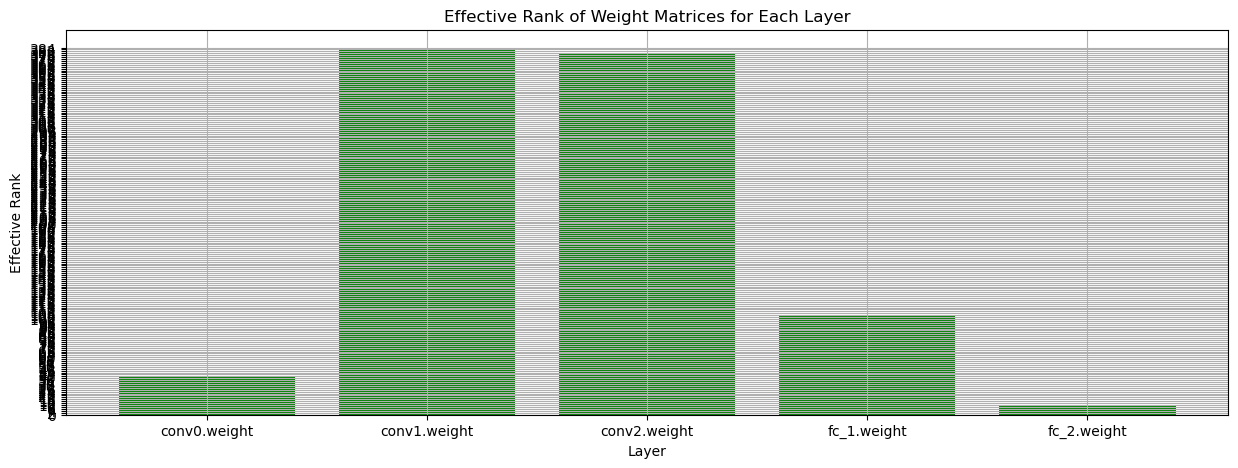

In [9]:
# Effective Rank of Pretrained model
plot_layer_effective_ranks(pretrained_model)  # Note: You'll need to define or load 'model' before calling this function


## Fine-tuning Experiments

In [10]:
learning_rates = [0.0001]   # later change when we have lr per layer
results = []

In [11]:
#training of baseline, end to end, models (#trials x #percentages)

dataloader_wrapped.update_phase('finetune')

# template_model = generate_cnn(input_dim = 28, output_dim = 10, depth = params['depth'], num_channels = params['width'],
#                      hidden_dim_lin = params['hidden_dim_lin'], kernel_size = params['kernel_size'], activation_function = params["activation_function"], use_pooling=params['use_pooling'])

for lr in learning_rates:
    params["lr"] = lr
    for sampled_percentage in percentages:      
        for sampled_percentage in percentages:
            if sampled_percentage <= 0.01:
                repeats = 10
            elif sampled_percentage < 0.5:
                repeats = 5
            else:
                repeats = 3
            
            for repeat in range(repeats):
                # Print or log the sampled values for transparency
                print(f"\nSampled Percentage: {sampled_percentage}, Lr: {lr}, Repeat: {repeat}")

                # Reduce the dataset
                train_loader_reduced = reduce_dataset(dataloader_wrapped.train_loader, sampled_percentage, seed = 42)
                torch.manual_seed(repeat)
                #train_loader_reduced = reduce_dataset(dataloader_wrapped.train_loader, sampled_percentage, seed = repeat)
                dataset_namespace_new = SimpleNamespace(train_loader=train_loader_reduced, test_loader=dataloader_wrapped.test_loader, val_loader=dataloader_wrapped.val_loader)

                # Copy and then cut the model - we already deepcopy it in the function: pretrained_model
                #model_temp = copy.deepcopy(template_model)
                model_temp = generate_cnn(input_dim = 28, output_dim = 10, depth = params['depth'], num_channels = params['width'],
                hidden_dim_lin = params['hidden_dim_lin'], kernel_size = params['kernel_size'], activation_function = params["activation_function"], use_pooling=params['use_pooling'])
                model_temp.to(device)

                # Train and evaluate
                trainer = Trainer(model_temp, dataset_namespace_new, params)
                train_acc, test_acc, effective_epochs, checkpoints = trainer.train(verbose=0)
                print(f"Training Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

                # Store the results
                results.append({"lr":lr, "sampled_percentage":sampled_percentage, "sampled_cut_point":-1, "repeat":repeat, "train_acc":train_acc, "test_acc":test_acc}) # -1 for the cut point means it's baseline


Sampled Percentage: 0.001, Lr: 0.0001, Repeat: 0
Early stopping invoked.
Training Accuracy: 0.2000, Test Accuracy: 0.2076

Sampled Percentage: 0.001, Lr: 0.0001, Repeat: 1
Early stopping invoked.
Training Accuracy: 0.2000, Test Accuracy: 0.2076

Sampled Percentage: 0.001, Lr: 0.0001, Repeat: 2
Early stopping invoked.
Training Accuracy: 0.2000, Test Accuracy: 0.1971

Sampled Percentage: 0.001, Lr: 0.0001, Repeat: 3
Early stopping invoked.
Training Accuracy: 0.2400, Test Accuracy: 0.2707

Sampled Percentage: 0.001, Lr: 0.0001, Repeat: 4
Early stopping invoked.
Training Accuracy: 0.6000, Test Accuracy: 0.3329

Sampled Percentage: 0.001, Lr: 0.0001, Repeat: 5
Early stopping invoked.
Training Accuracy: 0.4000, Test Accuracy: 0.3273

Sampled Percentage: 0.001, Lr: 0.0001, Repeat: 6
Early stopping invoked.
Training Accuracy: 0.4000, Test Accuracy: 0.2263

Sampled Percentage: 0.001, Lr: 0.0001, Repeat: 7
Early stopping invoked.
Training Accuracy: 0.2000, Test Accuracy: 0.2115

Sampled Percent

KeyboardInterrupt: 

In [12]:
print(results)

[{'lr': 0.0001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 0, 'train_acc': 0.2, 'test_acc': 0.20757045875334293}, {'lr': 0.0001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 1, 'train_acc': 0.2, 'test_acc': 0.20757045875334293}, {'lr': 0.0001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 2, 'train_acc': 0.2, 'test_acc': 0.19707879037235138}, {'lr': 0.0001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 3, 'train_acc': 0.24, 'test_acc': 0.2707261880271549}, {'lr': 0.0001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 4, 'train_acc': 0.6, 'test_acc': 0.332853322361654}, {'lr': 0.0001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 5, 'train_acc': 0.4, 'test_acc': 0.3272989096893643}, {'lr': 0.0001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 6, 'train_acc': 0.4, 'test_acc': 0.22629088664883767}, {'lr': 0.0001, 'sampled_percentage': 0.001, 'sampled_cut_point':

In [14]:
dataloader_wrapped.update_phase('finetune')

# Store results
#results = []
# Store unique combinations that have been tested: we need this if we want to test random combinations
# tested_combinations = set()

# for lr in learning_rates:
#     params["lr"] = lr
# repeating the whole thing with multiple lr and saving the results somewhere
for sampled_percentage in percentages:

    if sampled_percentage <= 0.01:
        repeats = 10
    elif sampled_percentage < 0.5:
        repeats = 5
    else:
        repeats = 3
        
    for sampled_cut_point in cuts:

        for repeat in range(repeats):
            # Add the combination to the tested set
            # tested_combinations.add((sampled_percentage, sampled_cut_point))

            # Print or log the sampled values for transparency
            print(f"\nSampled Percentage: {sampled_percentage}, Sampled Cut Point: {sampled_cut_point}, Lr: {lr}, Repeat: {repeat}")

            # Reduce the dataset
            train_loader_reduced = reduce_dataset(dataloader_wrapped.train_loader, sampled_percentage, seed=42)
            dataset_namespace_new = SimpleNamespace(train_loader=train_loader_reduced, test_loader=dataloader_wrapped.test_loader, val_loader=dataloader_wrapped.val_loader)
            torch.manual_seed(repeat) # because in the cut function we reinitialize some layers too (at least the dense layers)
            
            # Copy and then cut the model - we already deepcopy it in the function: pretrained_model
            model_new = cut_custom_cnn_model(pretrained_model, cut_point=sampled_cut_point, freeze=params["freeze"], reinitialize=params["reinit"])

            # Train and evaluate
            trainer = Trainer(model_new, dataset_namespace_new, params)
            train_acc, test_acc, effective_epochs, checkpoints = trainer.train(verbose=0)
            print(f"Training Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

            # Store the results
            results.append({"lr":lr, "sampled_percentage":sampled_percentage, "sampled_cut_point":sampled_cut_point, "repeat":repeat, "train_acc":train_acc, "test_acc":test_acc})


Sampled Percentage: 0.001, Sampled Cut Point: 0, Lr: 0.0001, Repeat: 0
Training Accuracy: 1.0000, Test Accuracy: 0.7322

Sampled Percentage: 0.001, Sampled Cut Point: 0, Lr: 0.0001, Repeat: 1
Early stopping invoked.
Training Accuracy: 1.0000, Test Accuracy: 0.6676

Sampled Percentage: 0.001, Sampled Cut Point: 0, Lr: 0.0001, Repeat: 2
Training Accuracy: 1.0000, Test Accuracy: 0.7219

Sampled Percentage: 0.001, Sampled Cut Point: 0, Lr: 0.0001, Repeat: 3
Training Accuracy: 1.0000, Test Accuracy: 0.7062

Sampled Percentage: 0.001, Sampled Cut Point: 0, Lr: 0.0001, Repeat: 4
Training Accuracy: 1.0000, Test Accuracy: 0.7215

Sampled Percentage: 0.001, Sampled Cut Point: 0, Lr: 0.0001, Repeat: 5
Training Accuracy: 1.0000, Test Accuracy: 0.7319

Sampled Percentage: 0.001, Sampled Cut Point: 0, Lr: 0.0001, Repeat: 6
Training Accuracy: 1.0000, Test Accuracy: 0.7171

Sampled Percentage: 0.001, Sampled Cut Point: 0, Lr: 0.0001, Repeat: 7
Training Accuracy: 1.0000, Test Accuracy: 0.7194

Sampled

In [ ]:
#save results
with open('results_lr_10_min_4.json', 'w') as f:
    json.dump(results, f)

#load results
with open('results.json', 'r') as f:
    results = json.load(f)

## Visualizations

### Print the results and save somewhere for future analysis

In [19]:
print(results)

[{'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 0, 'train_acc': 1.0, 'test_acc': 0.7395597613659741}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 1, 'train_acc': 1.0, 'test_acc': 0.7377082904752109}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 2, 'train_acc': 1.0, 'test_acc': 0.7683604196667353}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 3, 'train_acc': 1.0, 'test_acc': 0.768977576630323}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 4, 'train_acc': 1.0, 'test_acc': 0.7603373791400946}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 5, 'train_acc': 1.0, 'test_acc': 0.7080847562229994}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 6, 'train_acc': 1.0, 'test_acc': 0.7669203867516972}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat'

### The Results Table and 3D plot (both go into the report)

In [ ]:
{"lr":lr, "sampled_percentage":sampled_percentage, "sampled_cut_point":-1, "repeat":repeat, "train_acc":train_acc, "test_acc":test_acc}

In [23]:
results[10]

{'lr': 0.001,
 'sampled_percentage': 0.002,
 'sampled_cut_point': -1,
 'repeat': 0,
 'train_acc': 1.0,
 'test_acc': 0.7833779057807035}

In [22]:
# first of all convert results to df and calculate the mean and std of repats
repeats_mean = []
i = 0
for lr in learning_rates:
    for sampled_percentage in percentages:
        for sampled_cut_point in [-1]+cuts:
            
            train, test = [], []
            for repeat in range(repeats):
                if results[i]["repeat"] != repeat or results[i]["sampled_percentage"] != sampled_percentage or results[i]["sampled_cut_point"] != sampled_cut_point or results[i]["lr"] != lr:
                    print("i: ", i, "repeat: ", repeat)
                    break
                train.append(results[i]["train_acc"])
                test.append(results[i]["test_acc"])
                i += 1
            repeats_mean.append((sampled_percentage, sampled_cut_point, lr, np.mean(train), np.std(train), np.mean(test), np.std(test)))
df = pd.DataFrame(repeats_mean, columns=['Percentage', 'Cut Point', 'Learning Rate', 'Mean Train Accuracy', 'Std Train Accuracy', 'Mean Test Accuracy', 'Std Test Accuracy'])
df

i:  10 repeat:  0
i:  10 repeat:  0
i:  10 repeat:  0
i:  10 repeat:  0
i:  20 repeat:  0
i:  20 repeat:  0
i:  20 repeat:  0
i:  20 repeat:  0
i:  30 repeat:  0
i:  30 repeat:  0
i:  30 repeat:  0
i:  30 repeat:  0
i:  40 repeat:  0
i:  40 repeat:  0
i:  40 repeat:  0
i:  40 repeat:  0
i:  45 repeat:  5
i:  45 repeat:  0
i:  45 repeat:  0
i:  45 repeat:  0
i:  45 repeat:  0
i:  50 repeat:  5
i:  50 repeat:  0
i:  50 repeat:  0
i:  50 repeat:  0
i:  50 repeat:  0
i:  55 repeat:  5
i:  55 repeat:  0
i:  55 repeat:  0
i:  55 repeat:  0
i:  55 repeat:  0
i:  58 repeat:  3
i:  58 repeat:  0
i:  58 repeat:  0
i:  58 repeat:  0
i:  58 repeat:  0
i:  61 repeat:  3
i:  61 repeat:  0
i:  61 repeat:  0
i:  61 repeat:  0
i:  61 repeat:  0
i:  64 repeat:  3
i:  64 repeat:  0
i:  64 repeat:  0
i:  64 repeat:  0
i:  64 repeat:  0
i:  64 repeat:  0
i:  64 repeat:  0
i:  64 repeat:  0
i:  64 repeat:  0
i:  64 repeat:  0
i:  64 repeat:  0
i:  64 repeat:  0
i:  64 repeat:  0
i:  64 repeat:  0
i:  64 rep

/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/davidguzman/miniforge3/envs/pytorch/lib/python3.11/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype

,Percentage,Cut Point,Learning Rate,Mean Train Accuracy,Std Train Accuracy,Mean Test Accuracy,Std Test Accuracy
0,0.001,-1,0.0010,1.0,0.0,0.74857,0.025174
1,0.001,0,0.0010,NaN,NaN,NaN,NaN
2,0.001,1,0.0010,NaN,NaN,NaN,NaN
3,0.001,2,0.0010,NaN,NaN,NaN,NaN
4,0.001,3,0.0010,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
95,1.000,-1,0.0001,NaN,NaN,NaN,NaN
96,1.000,0,0.0001,NaN,NaN,NaN,NaN
97,1.000,1,0.0001,NaN,NaN,NaN,NaN
98,1.000,2,0.0001,NaN,NaN,NaN,NaN
